# Task 2
Train the CNN on training images pertaining to classes 0 to 9, and use the pretrained network to train on the [MNIST dataset](http://yann.lecun.com/exdb/mnist/).

Instructions:
- compare convergence time of pretrained network to that of randomly initialized network
- compare the final accuracies pretrained network and randomly initialized network
- save model checkpoints

In [ ]:
!pip install tensorflow_addons

     |████████████████████████████████| 706kB 25.0MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, Dense, MaxPool2D, Dropout
from tensorflow.keras.layers import BatchNormalization, Flatten, InputLayer

In [ ]:
DATA_PATH = '/content/drive/MyDrive/Modified MNIST/train/'
CKPT_PATH_PT = '/content/drive/MyDrive/Modified MNIST/checkpoints/ckpts-2/pretraining/'
CKPT_PATH_FT = '/content/drive/MyDrive/Modified MNIST/checkpoints/ckpts-2/finetuning/'

IMAGE_SHAPE = (64, 64, 3)
BATCH_SIZE = 128
NUM_CLASSES = 10
LEARNING_RATE = 5e-4
NUM_EPOCHS_PT = 200
NUM_EPOCHS_FT = 25

# Pretraining the Model on the given Dataset

## Data Loader

The `DataLoader()` loads, preprocesses, and returns a batch of images on the fly. For this task, only the data points corresponding to digits 0-9 are processed.

The following preprocessings are used:

- For validating the model's performance, an `80-20 train-val split` is made from the training dataset.
- The images are `reshaped to 64 x 64 x 3`.
- The images are `normalized to [0, 1]` by dividing each pixel value by 255.
- Since number of samples per class is small, data augmentation is used to synthetically increase the dataset's size. The augmentations are selected so as to ensure that they don't alter the underlying data distribution. For example, random flip cannot be used as it will mislead the model by changing 'p' to 'q', 'b' to 'd', '6' to '9', etc.
The following data augmentation techniques are used:
 - `random rotation` - rotates the images by atmost 20 degrees in clockwise or counter-clockwise direction.
 - `random central crop` - crops out the center part of the images. 
 - `brightness adjustment` - slightly alters the brightness level of the images.
- The colours in the images are `inverted`, i.e., black is converted into white and vice-versa. This is done to maintain consistency with the MNIST dataset and the task 3 dataset.


In [ ]:
class DataLoader():
  '''
    A class to fetch data for training and testing

    utilities:
      1. __init__()
      2. parse()
      3. get_ds_train()
      4. get_ds_dev()
      5. plot_samples()
  '''

  def __init__(self, path, image_shape, batch_size):
    ''' Generates a list of images and their corresponding labels '''

    path = path
    x_list = []
    y_list = []
    self.image_height = image_shape[0]
    self.image_width = image_shape[1]
    self.batch_size = batch_size

    for subdir, dirs, files in os.walk(path):
      for f in files:
        image_path = os.path.join(subdir, f)
        label = int(image_path.split('/')[6][-2:])
        if label <= 10:
          x_list.append(image_path)
          y_list.append(label)
    
    self.x_train, self.x_dev, self.y_train, self.y_dev = train_test_split(x_list, 
                                                                          y_list, 
                                                                          test_size = 0.2, 
                                                                          random_state = 1)
    self.mode = 'test'

  def parse(self, image_path, label):
    ''' Reads and preprocesses images, and converts labels into one-hot encodings '''

    def augment(image, label):
      image = tfa.image.rotate(image, 
                               0.01744 * np.random.uniform(-20.0, 20.0),
                               fill_mode = 'nearest')
      
      h, w, c = image.shape
      x = int(np.random.uniform(0.0, 0.2) * h)
      y = int(np.random.uniform(0.0, 0.2) * w)
      image = image[x:(h - x), y:(w - y), :]
      image = np.pad(image, ((x, x), (y, y), (0, 0)), constant_values = 255)
      return image, label

    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels = 3)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [self.image_height, self.image_width])
    if self.mode == 'train':
      image, label = tf.py_function(augment, [image, label], [tf.float32, tf.int32])
      image.set_shape((self.image_height, self.image_width, 3))
      label.set_shape(())
      image = tf.image.random_brightness(image, max_delta = 0.5)
    image = image / 255.
    image = tf.clip_by_value(image, 0.0, 1.0)
    image = 1 - image
    label -= 1
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

  def get_ds_train(self):
    ''' Returns training dataset '''

    BUFFER_SIZE = len(self.x_train)
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    self.mode = 'train'
    ds = tf.data.Dataset.from_tensor_slices((self.x_train, self.y_train))
    ds = ds.shuffle(BUFFER_SIZE)
    ds = ds.map(self.parse, num_parallel_calls = AUTOTUNE)
    ds = ds.batch(self.batch_size)
    ds = ds.prefetch(BUFFER_SIZE)
    return ds

  def get_ds_dev(self):
    ''' Returns dev dataset '''

    BUFFER_SIZE = len(self.x_dev)
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    self.mode = 'test'
    ds = tf.data.Dataset.from_tensor_slices((self.x_dev, self.y_dev))
    ds = ds.map(self.parse, num_parallel_calls = AUTOTUNE)
    ds = ds.batch(self.batch_size)
    ds = ds.prefetch(BUFFER_SIZE)
    return ds
  
  def plot_samples(self, ds, max = 10):
    ''' Plots samples of images from 'ds' '''

    count = 1
    plt.figure(figsize = (max, 5))
    for x, y in ds:
      for image, label in zip(x, y):
        plt.subplot(max // 5, 5, count)
        plt.imshow(image)
        plt.axis('off')
        count += 1
        if count == max + 1:
          break
      break
    plt.show()

Training Samples:


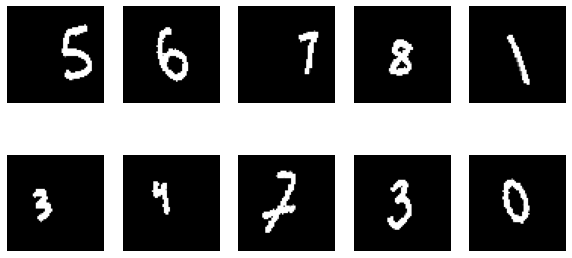


Validation Samples


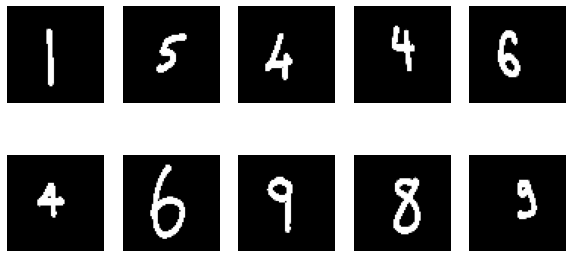

In [ ]:
dataloader = DataLoader(DATA_PATH, IMAGE_SHAPE, BATCH_SIZE)
ds_train = dataloader.get_ds_train()
ds_dev = dataloader.get_ds_dev()

print('Training Samples:')
dataloader.plot_samples(ds_train)
print('\nValidation Samples')
dataloader.plot_samples(ds_dev)

## Model

The `Model()` class defines the architecture of the CNN model. Model subclassing is used to define the model architecture.

In [ ]:
class Model(tf.keras.Model):
  '''
    The class defining model's architecture

    utilities:
      1. __init__()
      2. call()
  '''

  def __init__(self, num_classes, input_shape):
    ''' Define the layers on the model '''

    super(Model, self).__init__()
    self.conv11 = Conv2D(filters = 32, kernel_size = (5, 5), padding = 'same',
                        activation = 'relu', input_shape = input_shape)
    self.conv12 = Conv2D(filters = 32, kernel_size = (5, 5), padding = 'same',
                        activation = 'relu')
    self.pool1 = MaxPool2D((2, 2))
    self.dropout1 = Dropout(0.25)

    self.conv21 = Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', 
                         activation = 'relu')
    self.conv22 = Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', 
                         activation = 'relu')
    self.pool2 = MaxPool2D(pool_size = (2, 2), strides = (2, 2))
    self.dropout2 = Dropout(0.25)

    self.conv31 = Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', 
                         activation = 'relu')
    self.conv32 = Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', 
                         activation = 'relu')
    self.pool3 = MaxPool2D(pool_size = (2, 2), strides = (2, 2))
    self.dropout3 = Dropout(0.25)

    self.conv41 = Conv2D(filters = 256, kernel_size = (3, 3), padding = 'same', 
                         activation = 'relu')
    self.conv42 = Conv2D(filters = 256, kernel_size = (3, 3), padding = 'same', 
                         activation = 'relu')
    self.pool4 = MaxPool2D(pool_size = (2, 2), strides = (2, 2))
    self.dropout4 = Dropout(0.25)

    self.conv51 = Conv2D(filters = 512, kernel_size = (3, 3), padding = 'same', 
                         activation = 'relu')
    self.conv52 = Conv2D(filters = 512, kernel_size = (3, 3), padding = 'same', 
                         activation = 'relu')
    self.pool5 = MaxPool2D(pool_size = (2, 2), strides = (2, 2))
    self.dropout5 = Dropout(0.25)

    self.flatten = Flatten()
    self.dense1 = Dense(256, activation = 'relu')
    self.dropout01 = Dropout(0.4)
    self.dense2 = Dense(128, activation = 'relu')
    self.dropout02 = Dropout(0.4)
    self.dense3 = Dense(num_classes)
  
  def call(self, x, training = True):
    ''' Forward propogation of input 'x' '''

    z = self.conv11(x)
    z = self.conv12(z)
    z = self.pool1(z)
    z = self.dropout1(z, training = training)

    z = self.conv21(z)
    z = self.conv22(z)
    z = self.pool2(z)
    z = self.dropout2(z, training = training)

    z = self.conv31(z)
    z = self.conv32(z)
    z = self.pool3(z)
    z = self.dropout3(z, training = training)

    z = self.conv41(z)
    z = self.conv42(z)
    z = self.pool4(z)
    z = self.dropout4(z, training = training)

    z = self.conv51(z)
    z = self.conv52(z)
    z = self.pool5(z)
    z = self.dropout5(z, training = training)

    z = self.flatten(z)
    z = self.dense1(z)
    z = self.dropout01(z, training = training)

    z = self.dense2(z)
    z = self.dropout02(z, training = training)

    z = self.dense3(z)
    return z

In [ ]:
model = Model(NUM_CLASSES, IMAGE_SHAPE)

## Training

The `train()` function defines the training parameters, compiles the model and trains it. The following are the traininge parameters used:
- `RMSProp optimizer`
- `catergorical cross-entropy loss` - computes loss from logits returned by the model.
- `lr_scheduler` - reduces the learning rate by a factor of 0.9 when the val_accuracy does not increase for 7 epochs.
- `checkpoints` - monitors the val_accuracy and saves the weights of best model.

In [ ]:
def train(model, ds_train, ds_dev, learning_rate, num_epochs, ckpt_path):
  optimizer = tf.keras.optimizers.RMSprop(learning_rate = learning_rate)
  loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True)
  top2 = tf.keras.metrics.TopKCategoricalAccuracy(k = 2, name = 'top2')
  lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                      patience = 7,  
                                                      verbose = 1, 
                                                      factor = 0.9, 
                                                      min_lr = 0.00001)
  checkpoint = tf.keras.callbacks.ModelCheckpoint(ckpt_path,
                                                  monitor = 'val_accuracy',
                                                  save_best_only = True, 
                                                  save_weights_only = True)

  model.compile(optimizer = optimizer,
                loss = loss, 
                metrics = ['accuracy'])
  
  model.fit(ds_train,
            epochs = num_epochs,
            validation_data = ds_dev,
            callbacks = [checkpoint, lr_scheduler])

In [ ]:
train(model, ds_train, ds_dev, LEARNING_RATE, NUM_EPOCHS_PT, CKPT_PATH_PT) 

Epoch 1/200
3/3 [==============================] - 8s 2s/step - loss: 2.3147 - accuracy: 0.1021 - val_loss: 2.3069 - val_accuracy: 0.0500
Epoch 2/200
3/3 [==============================] - 5s 2s/step - loss: 2.3004 - accuracy: 0.1369 - val_loss: 2.3091 - val_accuracy: 0.0875
Epoch 3/200
3/3 [==============================] - 5s 2s/step - loss: 2.3037 - accuracy: 0.0893 - val_loss: 2.3155 - val_accuracy: 0.0500
Epoch 4/200
3/3 [==============================] - 6s 2s/step - loss: 2.3010 - accuracy: 0.1025 - val_loss: 2.3063 - val_accuracy: 0.0500
Epoch 5/200
3/3 [==============================] - 5s 2s/step - loss: 2.3000 - accuracy: 0.1025 - val_loss: 2.3068 - val_accuracy: 0.0500
Epoch 6/200
3/3 [==============================] - 5s 2s/step - loss: 2.3019 - accuracy: 0.0971 - val_loss: 2.3095 - val_accuracy: 0.0500
Epoch 7/200
3/3 [==============================] - 6s 2s/step - loss: 2.2986 - accuracy: 0.1102 - val_loss: 2.3056 - val_accuracy: 0.0500
Epoch 8/200
3/3 [=================

# Finetuning the Model on the MNIST Dataset

## MNIST Dataset

The `MNIST()` loads, preprocesses, and returns a batch of MNIST images on the fly. The dataset is loaded from TFDS as it has the desired training and testing split (as specified [here](http://yann.lecun.com/exdb/mnist/)).

The following preprocessings are used:

- The images are `reshaped to 64 x 64 x 3`.
- The images are `normalized to [0, 1]` by dividing each pixel value by 255.
- The images are `tiled to get 3 channels` in the image.


In [ ]:
class MNIST():
  '''
    A class to fetch MNIST data for training and testing

    utilities:
      1. __init__()
      2. load_data()
      3. plot_samples()
  '''

  def __init__(self, image_shape, batch_size):
    ''' Defines class variables '''

    self.image_height = image_shape[0]
    self.image_width = image_shape[1]
    self.batch_size = batch_size

  def load_data(self):
    ''' Loads and preprocessed the training and testing data '''

    (ds_train, ds_test), ds_info = tfds.load('mnist',
                                             split = ['train', 'test'],
                                             shuffle_files = True,
                                             as_supervised = True,
                                             with_info = True)

    def parse(image, label):
      image = tf.cast(image, tf.float32) / 255.
      image = tf.tile(image, [1, 1, 3])
      image = tf.image.resize(image, [self.image_height, self.image_width])
      label = tf.one_hot(label, NUM_CLASSES)
      return image, label
    
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    ds_train = ds_train.map(parse, num_parallel_calls = AUTOTUNE)
    ds_train = ds_train.cache()
    ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
    ds_train = ds_train.batch(self.batch_size)
    ds_train = ds_train.prefetch(AUTOTUNE)

    ds_test = ds_test.map(parse, num_parallel_calls = AUTOTUNE)
    ds_test = ds_test.batch(self.batch_size)
    ds_test = ds_test.prefetch(AUTOTUNE)

    return (ds_train, ds_test), ds_info

  def plot_samples(self, ds, max = 10):
    ''' Plots samples of images from 'ds' '''

    count = 1
    plt.figure(figsize = (max, 5))
    for x, y in ds:
      for image, label in zip(x, y):
        plt.subplot(max // 5, 5, count)
        plt.imshow(image)
        plt.axis('off')
        count += 1
        if count == max + 1:
          break
      break
    plt.show()

Training Samples:


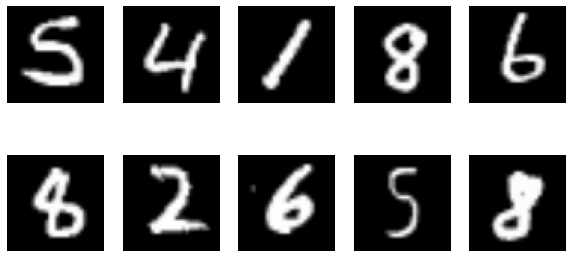


Testing Samples


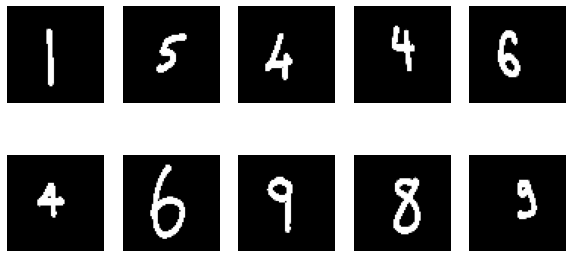

In [ ]:
dataloader = MNIST(IMAGE_SHAPE, BATCH_SIZE)
(ds_train, ds_test), ds_info = dataloader.load_data()

print('Training Samples:')
dataloader.plot_samples(ds_train)
print('\nTesting Samples')
dataloader.plot_samples(ds_dev)

## Model

The model is loaded and initialized with the weights of the pretrained model.

In [ ]:
model = Model(NUM_CLASSES, IMAGE_SHAPE)
model.load_weights(CKPT_PATH_PT)

## Training

Using the same training parameters we used for pretraining, the model is finetuned for the MNIST dataset.

In [ ]:
train(model, ds_train, ds_test, LEARNING_RATE, NUM_EPOCHS_FT, CKPT_PATH_FT)

Epoch 1/25
469/469 [==============================] - 34s 69ms/step - loss: 0.3211 - accuracy: 0.9183 - val_loss: 0.0557 - val_accuracy: 0.9834
Epoch 2/25
469/469 [==============================] - 32s 68ms/step - loss: 0.0897 - accuracy: 0.9759 - val_loss: 0.0412 - val_accuracy: 0.9879
Epoch 3/25
469/469 [==============================] - 32s 67ms/step - loss: 0.0712 - accuracy: 0.9820 - val_loss: 0.0320 - val_accuracy: 0.9915
Epoch 4/25
469/469 [==============================] - 32s 68ms/step - loss: 0.0504 - accuracy: 0.9862 - val_loss: 0.0324 - val_accuracy: 0.9904
Epoch 5/25
469/469 [==============================] - 32s 68ms/step - loss: 0.0446 - accuracy: 0.9883 - val_loss: 0.0278 - val_accuracy: 0.9924
Epoch 6/25
469/469 [==============================] - 32s 68ms/step - loss: 0.0393 - accuracy: 0.9897 - val_loss: 0.0239 - val_accuracy: 0.9930
Epoch 7/25
469/469 [==============================] - 32s 68ms/step - loss: 0.0354 - accuracy: 0.9903 - val_loss: 0.0230 - val_accuracy:

# Training the Model on MNIST Dataset from Scratch

The pipeling used in this step is the same as that used in `Finetuning the Model on MNIST Dataset`, except the model is randomly initialized.

In [ ]:
dataloader = MNIST(IMAGE_SHAPE, BATCH_SIZE)
(ds_train, ds_test), ds_info = dataloader.load_data()

In [ ]:
model = Model(NUM_CLASSES, IMAGE_SHAPE)

In [ ]:
train(model, ds_train, ds_test, LEARNING_RATE, NUM_EPOCHS_FT, CKPT_PATH_FT)

Epoch 1/25
469/469 [==============================] - 41s 68ms/step - loss: 1.5026 - accuracy: 0.4582 - val_loss: 0.0839 - val_accuracy: 0.9786
Epoch 2/25
469/469 [==============================] - 32s 67ms/step - loss: 0.1114 - accuracy: 0.9739 - val_loss: 0.0405 - val_accuracy: 0.9895
Epoch 3/25
469/469 [==============================] - 31s 67ms/step - loss: 0.0650 - accuracy: 0.9835 - val_loss: 0.0394 - val_accuracy: 0.9910
Epoch 4/25
469/469 [==============================] - 31s 67ms/step - loss: 0.0507 - accuracy: 0.9869 - val_loss: 0.0305 - val_accuracy: 0.9917
Epoch 5/25
469/469 [==============================] - 31s 67ms/step - loss: 0.0511 - accuracy: 0.9878 - val_loss: 0.0239 - val_accuracy: 0.9925
Epoch 6/25
469/469 [==============================] - 31s 67ms/step - loss: 0.0450 - accuracy: 0.9898 - val_loss: 0.0341 - val_accuracy: 0.9921
Epoch 7/25
469/469 [==============================] - 31s 67ms/step - loss: 0.0483 - accuracy: 0.9893 - val_loss: 0.0249 - val_accuracy:

# Analysis

- The model initialized with pretrained weights achieves a higher accuracy of 99.57% on the validation set. The randomly initialized model attains the highest accuracy of 99.47%
- In terms of convergence, both have similar convergence time.